### Imports

In [1]:
import matplotlib.pyplot as plt
import librosa
from librosa import display
from scipy import signal
from scipy.io import wavfile
import numpy as np
import pandas as pd
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from os import listdir
from os.path import isdir, exists
import statistics
import seaborn as sns
import h5py
import json

from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import ConfusionMatrixDisplay, precision_score, recall_score, balanced_accuracy_score, accuracy_score, f1_score
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.image import img_to_array, load_img, array_to_img, ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, MaxPooling2D, Conv2D, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import warnings

import tensorflow as tf
np.random.seed(423)

### Testing area

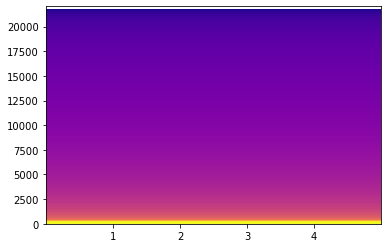

In [163]:
plt.specgram(np.concatenate([np.array(one_second * 5), np.repeat(last_second, 5)]),
    Fs=44100, cmap="plasma", NFFT=256, scale_by_freq=False, scale='dB');


In [10]:
# sample_rate, samples = wavfile.read('../audio_files/mono/sine_440.wav')
# frequencies, times, spectrogram = signal.spectrogram(samples, sample_rate)

# # print(sample_rate, samples)

# # plt.specgram(samples, Fs=440, cmap="rainbow");
# D = np.abs(librosa.stft(librosa.load('../audio_files/mono/sine_440.wav')))
# DB = librosa.amplitude_to_db(D, ref=np.max)
# librosa.display.specshow(DB, sr=sample_rate, hop_length=512, x_axis='time', y_axis='log');



# # plt.pcolormesh(times, frequencies, spectrogram)
# # plt.imshow(spectrogram)
# # plt.ylabel('Frequency [Hz]')
# # plt.xlabel('Time [sec]')
# # plt.show()

(array([ 1092,  1247,  1403, ..., -1557, -1403, -1247], dtype=int16),
 array([   0,  205,  409, ..., -612, -409, -205], dtype=int16))

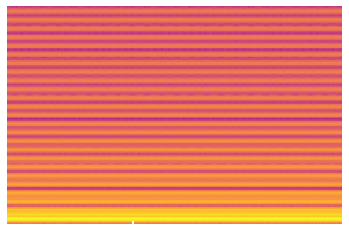

In [178]:
file_name = 'audio_files/mono/one_offs/sine_ableton.wav'

sample_rate, samples = wavfile.read('../' + file_name)
sample_rate, samples2 = wavfile.read('../' + 'audio_files/mono/one_offs/sine_440.wav')
# frequencies, times, spectrogram = signal.spectrogram(samples, sample_rate)

# print(sample_rate, samples)
# plt.figure(figsize=(12, 8))
with plt.ioff():
    plt.specgram(samples[:, 0], Fs=sample_rate, cmap="plasma", NFFT=256);
    plt.axis('off');
# plt.savefig('test.png', bbox_inches='tight')

# plt.pcolormesh(times, frequencies, spectrogram)
# plt.imshow(spectrogram)
# plt.ylabel('Frequency [Hz]')
# plt.xlabel('Time [sec]')
# plt.show()
samples[:, 0], samples2

In [39]:
# for i in samples[:, 0][44100*6:44100*7]:
#     print(i)

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [14]:
# from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
# from matplotlib.figure import Figure

# fig = plt.Figure()
# ax = fig.add_subplot(111)
# ax.specgram(samples, Fs=sample_rate, cmap="plasma", NFFT=256)
# ax.axis('off');
# canvas = FigureCanvas(fig)
# canvas.print_figure('sample.png', bbox_inches='tight')

In [17]:
# im = load_img('../audio_files/mono/basic_waves_ads/sine/ads_A♯5_9.png')

In [3]:
[4] * 4

[4, 4, 4, 4]

In [18]:
# img_to_array(im).shape

### Helper functions

In [5]:
# function for saving models with classes
# code from https://stackoverflow.com/questions/44310448/attaching-class-labels-to-a-keras-model
def save_model_ext(model, filepath, overwrite=True, meta_data=None):
    tf.keras.models.save_model(model, filepath, overwrite)
    if meta_data is not None:
        f = h5py.File(filepath, mode='a')
        f.attrs['my_meta_data'] = meta_data
        f.close()

### Function for making visualizations using the .wav samples
def wav_to_plots(folder_name, spec=True, adsr=True, subfolders=True):
    wav_path = f'../audio_files/mono/{folder_name}/wavs'
    spec_path = f'../audio_files/mono/{folder_name}/spectrograms'
    adsr_path = f'../audio_files/mono/{folder_name}/adsr_plots'

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        # portion of code for when subfolders are included
        if (subfolders == True): # if a folder with subfolders
            for subfolder in listdir(wav_path):
                if isdir(f'{wav_path}/{subfolder}'): # if given filepath is actually a subfolder
                    for w in listdir(f'{wav_path}/{subfolder}'):
                        w_name = w.split('.')[0]
                        # check if spectrogram exists already
                        if exists(f'{spec_path}/{subfolder}/{w_name}') == False:
                            # spectrograms
                            try:
                                if (spec):
                                    # read wavefile
                                    sample_rate, samples = wavfile.read(f'{wav_path}/{subfolder}/{w}')
                                    with plt.ioff():
                                        # code from https://stackoverflow.com/questions/44165411/most-efficient-way-to-generate-many-figures-with-matplotlib
                                        fig = plt.Figure()
                                        ax = fig.add_subplot(111)
                                        ax.specgram(samples, Fs=sample_rate, cmap="plasma", NFFT=256, mode='default')
                                        ax.axis('off')
                                        canvas = FigureCanvas(fig)
                                        canvas.print_figure(f'{spec_path}/{subfolder}/{w}.png', bbox_inches='tight')
                                if (adsr): # adsr plot
                                    audio_sample = librosa.load(f'{wav_path}/{subfolder}/{w}')
                            
                                    with plt.ioff():
                                        fig = plt.Figure()
                                        ax = fig.add_subplot(111)
                                        ax.plot(audio_sample[0])
                                        ax.axis('off')
                                        canvas = FigureCanvas(fig)
                                        w_name = w.split('.')[0]
                                        canvas.print_figure(f'{adsr_path}/{subfolder}_{w_name}.png', bbox_inches='tight')
                            except: # catches the .DS_Store files
                                print(f'Error with file at {wav_path}/{subfolder}/{w}')
        # when no subfolders are included
        else:
            for w in listdir(wav_path):
                w_name = w.split('.')[0]
                # print(f'{spec_path}/{subfolder}/{w_name}')
                # check if spectrogram exists already
                if exists(f'{spec_path}/{w_name}.png') == False:
                    # spectrograms
                    try:
                        if (spec): # spectrogram
                            sample_rate, samples = wavfile.read(f'{wav_path}/{w}')
                            with plt.ioff():
                                fig = plt.Figure()
                                ax = fig.add_subplot(111)
                                ax.specgram(samples, Fs=sample_rate, cmap="plasma", NFFT=256, mode='default')
                                ax.axis('off')
                                canvas = FigureCanvas(fig)
                                canvas.print_figure(f'{spec_path}/{w_name}.png', bbox_inches='tight')
                        if (adsr): # adsr plot
                            audio_sample = librosa.load(f'{wav_path}/{w}')
                    
                            with plt.ioff():
                                fig = plt.Figure()
                                ax = fig.add_subplot(111)
                                ax.plot(audio_sample[0])
                                ax.axis('off')
                                canvas = FigureCanvas(fig)
                                canvas.print_figure(f'{adsr_path}/{w_name}.png', bbox_inches='tight')
                    except: # catches the .DS_Store files
                        print(f'Error with file at {wav_path}/{w}')



## Modeling

### CNN Models - Group 1 (basic_waves)

##### Four different waveforms, 12 notes, 5 octaves (2-6) - No variation in adsr, or any other modulation

#### Model 1.1 - CNN - Identifying the waveforms - no modulations

In [165]:
# data gen
datagen = ImageDataGenerator(validation_split=0.2)

train_gen = datagen.flow_from_directory(
    '../audio_files/mono/basic_waves/',
    target_size=(389,515),
    class_mode='categorical',
    batch_size=32,
    subset='training'
)

test_gen = datagen.flow_from_directory(
    '../audio_files/mono/basic_waves/',
    target_size=(389,515),
    class_mode='categorical',
    batch_size=32,
    subset='validation'
)
model1 = Sequential()

model1.add(Conv2D(32, (4,4), activation='relu', input_shape=(389,515,3)))
model1.add(MaxPooling2D(pool_size=(4,4)))

model1.add(Conv2D(32, (4,4), activation='relu', input_shape=(389,515,3)))
model1.add(MaxPooling2D(pool_size=(4,4)))

model1.add(Flatten())
model1.add(Dense(35, activation='relu'))
model1.add(Dense(4, activation='softmax'))

es = EarlyStopping(
    monitor = 'val_accuracy',
    verbose = 1,
    mode='max',
    patience=4
)

mc = ModelCheckpoint(
    filepath='models/model1.1mc{epoch:02d}-{val_accuracy:.2f}',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    initial_value_threshold=.85
)

model1.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history1 = model1.fit(train_gen, validation_data=test_gen, epochs=25, callbacks=[es, mc])

Found 400 images belonging to 4 classes.
Found 100 images belonging to 4 classes.
Epoch 1/25
 1/13 [=>............................] - ETA: 36s - loss: 56.5128 - accuracy: 0.1250

KeyboardInterrupt: 

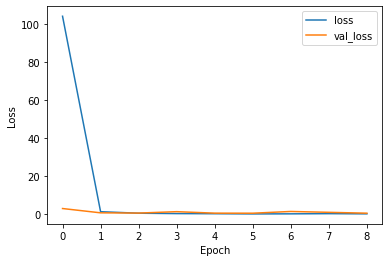

In [6]:
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.legend(['loss', 'val_loss'])

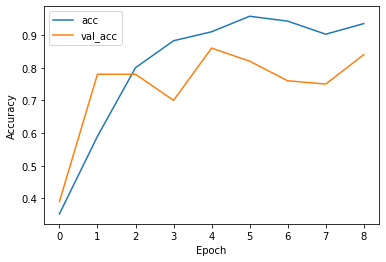

In [7]:
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.legend(['acc', 'val_acc'])

In [8]:
preds = model1.predict(test_gen)

ConfusionMatrixDisplay.from_predictions(y_true=test_gen.classes, y_pred=np.argmax(preds, axis=1), labels=test_gen.class_indices.values)

TypeError: '<' not supported between instances of 'builtin_function_or_method' and 'int'

In [39]:
np.argmax(preds, axis=1), test_gen.classes

(array([1, 0, 0, 3, 3, 1, 3, 0, 0, 0, 1, 1, 2, 0, 3, 3, 3, 1, 3, 1, 1, 0,
        1, 2, 2, 3, 1, 3, 2, 2, 1, 3, 2, 3, 0, 2, 0, 1, 2, 3, 2, 0, 3, 3,
        2, 0, 1, 1, 1, 0, 1, 3, 1, 2, 3, 2, 1, 3, 2, 1, 1, 1, 1, 1, 3, 0,
        2, 0, 1, 3, 2, 2, 2, 0, 2, 1, 0, 0, 2, 0, 0, 3, 2, 1, 2, 1, 3, 3,
        1, 0, 3, 3, 2, 0, 3, 1, 1, 0, 0, 1]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], dtype=int32))

In [70]:
# model.save('models/model1.1-basic_waves') # 89% val accuracy on final epoch

INFO:tensorflow:Assets written to: models/model1.1-basic_waves/assets


In [32]:
train_gen.class_indices

{'saw': 0, 'sine': 1, 'sq': 2, 'tri': 3}

In [46]:
model = tf.keras.models.load_model('models/model1.1mc13-0.92')

In [48]:
# predict an image

img_file_path = '../' + 'audio_files/mono/basic_waves/saw/ads_A♯5_24.png'

img_array = img_to_array(load_img(img_file_path, target_size=(389, 515)))
img_batch = np.expand_dims(img_array, axis=0)
# img_preprocessed = preprocess_input(img_batch)
[key for key, val in train_gen.class_indices.items() if val == model.predict(img_batch).argmax(-1)[0]][0]

UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x1a2462930>

/Users/kalebtsegaye/opt/anaconda3/envs/live-params/lib/python3.10/site-packages/matplotlib/axes/_axes.py:7622: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


array([  0, 255, 255, ..., 255, 255, 255], dtype=uint8)

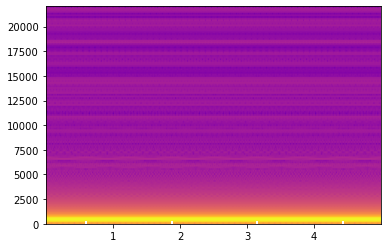

In [71]:
file_name = 'audio_files/mono/one_offs/sine_400.wav'

# predict an image

with plt.ioff():
    # plt.figure(figsize=(12, 8))
    # code from https://stackoverflow.com/questions/44165411/most-efficient-way-to-generate-many-figures-with-matplotlib
    sample_rate, samples = wavfile.read('../' + file_name)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.specgram(samples, Fs=sample_rate, cmap="plasma", NFFT=256)
    # ax.axis('off')
    # code from https://stackoverflow.com/questions/7821518/matplotlib-save-plot-to-numpy-array
    fig.canvas.draw()

    # Now we can save it to a numpy array.
    data = np.frombuffer(fig.canvas.tostring_argb(), dtype=np.uint8)
    # data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))


# img_batch = np.expand_dims(img_array, axis=0)
# # img_preprocessed = preprocess_input(img_batch)
# [key for key, val in train_gen.class_indices.items() if val == model.predict(img_batch).argmax(-1)[0]][0]
data

### Group 2 (2_basic_waves_adsr)

In [114]:
group_folder_name = '2_basic_waves_adsr'

In [7]:
# wav_to_plots(folder_name=group_folder_name)

#### Model 2.1 - CNN - Identifying the waveforms - ADSR modulation

Still 12 notes, now 9 octaves (1-9), and, of course, adsr

In [64]:
# data gen
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

folder_name = '2_basic_waves_adsr'
spec_path = f'../audio_files/mono/{folder_name}/spectrograms'

train_gen = datagen.flow_from_directory(
    spec_path,
    classes=['saw', 'sine', 'sq', 'tri'],
    class_mode='categorical',
    batch_size=32,
    subset='training'
)

test_gen = datagen.flow_from_directory(
    spec_path,
    classes=['saw', 'sine', 'sq', 'tri'],
    class_mode='categorical',
    batch_size=32,
    subset='validation'
)
model2_1 = Sequential()

model2_1.add(Conv2D(32, (4,4), activation='relu', input_shape=(256,256,3)))
model2_1.add(MaxPooling2D(pool_size=(4,4)))

model2_1.add(Conv2D(32, (4,4), activation='relu', input_shape=(256,256,3)))
model2_1.add(MaxPooling2D(pool_size=(4,4)))

model2_1.add(Flatten())
model2_1.add(Dense(35, activation='relu'))
model2_1.add(Dense(4, activation='softmax'))

es = EarlyStopping(
    monitor = 'val_accuracy',
    verbose = 1,
    mode='max',
    patience=7
)

mc = ModelCheckpoint(
    filepath='models/model2.1mc{epoch:02d}-val_acc{val_accuracy:.2f}',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    initial_value_threshold=.75
)

model2_1.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history2_1 = model2_1.fit(train_gen, validation_data=test_gen, epochs=25, callbacks=[es, mc])

Found 400 images belonging to 4 classes.
Found 100 images belonging to 4 classes.
Epoch 1/25
13/13 [==============================] - 6s 434ms/step - loss: 1.2651 - accuracy: 0.4325 - val_loss: 0.8888 - val_accuracy: 0.6500
Epoch 2/25
13/13 [==============================] - 5s 419ms/step - loss: 0.8707 - accuracy: 0.5575 - val_loss: 0.8139 - val_accuracy: 0.5800
Epoch 3/25
13/13 [==============================] - 5s 433ms/step - loss: 0.7765 - accuracy: 0.6000 - val_loss: 0.7503 - val_accuracy: 0.6500
Epoch 4/25
13/13 [==============================] - 5s 417ms/step - loss: 0.7509 - accuracy: 0.6375 - val_loss: 0.7469 - val_accuracy: 0.6200
Epoch 5/25
13/13 [==============================] - 6s 419ms/step - loss: 0.7114 - accuracy: 0.6450 - val_loss: 0.7759 - val_accuracy: 0.5400
Epoch 6/25
13/13 [==============================] - 6s 421ms/step - loss: 0.6800 - accuracy: 0.6875 - val_loss: 0.6645 - val_accuracy: 0.6400
Epoch 7/25
13/13 [==============================] - 6s 424ms/step 

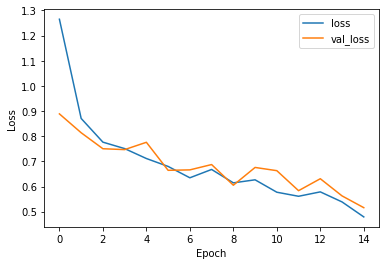

In [65]:
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(history2_1.history['loss'])
plt.plot(history2_1.history['val_loss'])
plt.legend(['loss', 'val_loss'])

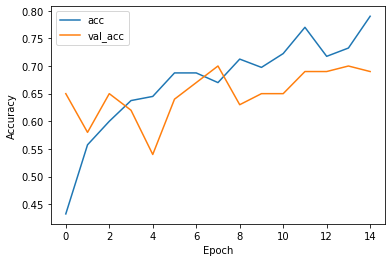

In [66]:
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(history2_1.history['accuracy'])
plt.plot(history2_1.history['val_accuracy'])
plt.legend(['acc', 'val_acc'])

##### Labels:

In [12]:
model = tf.keras.models.load_model('models/model2.1mc15-val_acc0.88')

save_model_ext(model, filepath='models/model2.1mc15-val_acc0.88metadata.h5', overwrite=True, meta_data=json.dumps({'saw': 0, 'sine': 1, 'sq': 2, 'tri': 3}))

In [7]:
wd = {'saw': 0, 'sine': 1, 'sq': 2, 'tri': 3}

json.dumps(wd)

'{"saw": 0, "sine": 1, "sq": 2, "tri": 3}'

In [32]:
train_gen.class_indices

{'saw': 0, 'sine': 1, 'sq': 2, 'tri': 3}

##### Loading model, testing model

In [37]:
model = tf.keras.models.load_model('models/model2.1mc15-val_acc0.88')

In [34]:
# predict an image
folder_name = '2_basic_waves_adsr'
spec_path = f'../audio_files/mono/{folder_name}/spectrograms'

predictions = {'sine':[], 'saw':[], 'sq':[], 'tri':[]}

for subfolder in listdir(spec_path):
    if isdir(f'{spec_path}/{subfolder}'):
        for w in listdir(f'{spec_path}/{subfolder}'):
            # try:
            img_array = img_to_array(load_img(f'{spec_path}/{subfolder}/{w}', target_size=(389, 515)))
            img_batch = np.expand_dims(img_array, axis=0)
            predictions[subfolder].append(model.predict(img_batch).argmax(-1)[0])

In [35]:
for key, val in predictions.items():
    print(key, statistics.mode(val), val.count(statistics.mode(val))/len(val))

sine 1 0.456
saw 0 0.896
sq 0 0.52
tri 3 0.312


#### Model 2.2: ADSR Estimation

In [116]:
data = pd.read_csv(f'../audio_files/mono/{group_folder_name}/file_data.csv').drop('Unnamed: 0', axis = 1)

In [117]:
data['file_name'] = data['file_name'] + '.png'
data

,file_name,wave,note,octave,note_octave,freq,attack_duration,decay_duration,sustain_level,sustain_duration,release_duration
0,sine/adsr_D♯5_1.wav.png,sine/adsr,D♯,5,D♯5,622.253967,4.013292,1.263828,0.723298,3.441122,1.159768
1,sine/adsr_E6_2.wav.png,sine/adsr,E,6,E6,1318.510228,1.617495,2.929420,0.744542,2.059110,1.812222
2,sine/adsr_C1_3.wav.png,sine/adsr,C,1,C1,32.703196,4.265106,1.609075,0.187103,1.099399,2.429497
3,sine/adsr_G8_4.wav.png,sine/adsr,G,8,G8,6271.926976,0.918339,2.958791,0.688149,1.085055,1.506915
4,sine/adsr_C♯4_5.wav.png,sine/adsr,C♯,4,C♯4,277.182631,2.069040,3.987323,0.643333,0.276730,1.975747
...,...,...,...,...,...,...,...,...,...,...,...
495,saw/adsr_B3_121.wav.png,saw/adsr,B,3,B3,246.941651,0.675360,0.863886,0.463540,3.391712,1.920458
496,saw/adsr_D9_122.wav.png,saw/adsr,D,9,D9,9397.272573,4.256398,0.194066,0.034862,3.142168,2.407368
497,saw/adsr_G♯2_123.wav.png,saw/adsr,G♯,2,G♯2,103.826174,2.858531,3.777678,0.290850,0.093278,0.389784
498,saw/adsr_D♯1_124.wav.png,saw/adsr,D♯,1,D♯1,38.890873,3.262614,2.066049,0.677198,3.107983,1.563354


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   file_name         500 non-null    object 
 1   wave              500 non-null    object 
 2   note              500 non-null    object 
 3   octave            500 non-null    int64  
 4   note_octave       500 non-null    object 
 5   freq              500 non-null    float64
 6   attack_duration   500 non-null    float64
 7   decay_duration    500 non-null    float64
 8   sustain_level     500 non-null    float64
 9   sustain_duration  500 non-null    float64
 10  release_duration  500 non-null    float64
dtypes: float64(6), int64(1), object(4)
memory usage: 43.1+ KB


In [29]:
print(group_folder_name)

2_basic_waves_adsr


In [11]:
# data gen
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

adsr_path = f'../audio_files/mono/{group_folder_name}/adsr_plots'

y_cols = ['attack_duration', 'decay_duration', 'sustain_level',	'sustain_duration',	'release_duration']

train_gen = datagen.flow_from_dataframe(
    data,
    x_col='file_name',
    y_col=y_cols,
    directory=adsr_path,
    class_mode='raw',
    batch_size=32,
    subset='training'
)

test_gen = datagen.flow_from_dataframe(
    data,
    x_col='file_name',
    y_col=y_cols,
    directory=adsr_path,
    class_mode='raw',
    batch_size=32,
    subset='validation'
)

folder_name = '2_basic_waves_adsr'
adsr_path = f'../audio_files/mono/{group_folder_name}/adsr_plots'

model2_2 = Sequential()

model2_2.add(Conv2D(32, (8,8), activation='relu', input_shape=(256,256,3)))
model2_2.add(MaxPooling2D(pool_size=(4,4)))

model2_2.add(Conv2D(32, (8,8), activation='relu', input_shape=(256,256,3)))
model2_2.add(MaxPooling2D(pool_size=(4,4)))

model2_2.add(Flatten())
model2_2.add(Dense(35, activation='relu'))
model2_2.add(Dense(5))

es = EarlyStopping(
    monitor = 'val_mean_squared_error',
    verbose = 1,
    mode='min',
    patience=7
)

mc = ModelCheckpoint(
    filepath='models/model2.2mc{epoch:02d}-val_mse{val_mean_squared_error:.2f}',
    monitor='val_mean_squared_error',
    mode='min',
    save_best_only=True,
    initial_value_threshold=.5
)

model2_2.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=['mean_absolute_error', 'mean_squared_error']
)

history2_2 = model2_2.fit(
    train_gen,
    validation_data=test_gen,
    # y=y_cols,
    # y=
    epochs=25,
    callbacks=[es, mc])

Found 400 validated image filenames.
Found 100 validated image filenames.


2022-06-07 15:26:31.765324: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/25
13/13 [==============================] - 22s 2s/step - loss: 2.2476 - mean_absolute_error: 1.1949 - mean_squared_error: 2.2476 - val_loss: 1.8572 - val_mean_absolute_error: 1.1693 - val_mean_squared_error: 1.8572
Epoch 2/25
13/13 [==============================] - 22s 2s/step - loss: 1.4441 - mean_absolute_error: 0.9811 - mean_squared_error: 1.4441 - val_loss: 1.3811 - val_mean_absolute_error: 0.9509 - val_mean_squared_error: 1.3811
Epoch 3/25
13/13 [==============================] - 22s 2s/step - loss: 1.2504 - mean_absolute_error: 0.8917 - mean_squared_error: 1.2504 - val_loss: 1.2413 - val_mean_absolute_error: 0.9032 - val_mean_squared_error: 1.2413
Epoch 4/25
13/13 [==============================] - 22s 2s/step - loss: 1.1341 - mean_absolute_error: 0.8539 - mean_squared_error: 1.1341 - val_loss: 1.1708 - val_mean_absolute_error: 0.8817 - val_mean_squared_error: 1.1708
Epoch 5/25
13/13 [==============================] - 22s 2s/step - loss: 1.0715 - mean_absolute_error: 0.

2022-06-07 15:31:56.880116: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: models/model2.2mc15-val_mse0.47/assets
13/13 [==============================] - 22s 2s/step - loss: 0.3951 - mean_absolute_error: 0.4629 - mean_squared_error: 0.3951 - val_loss: 0.4703 - val_mean_absolute_error: 0.4987 - val_mean_squared_error: 0.4703
Epoch 16/25
13/13 [==============================] - 22s 2s/step - loss: 0.3540 - mean_absolute_error: 0.4339 - mean_squared_error: 0.3540 - val_loss: 0.4415 - val_mean_absolute_error: 0.4795 - val_mean_squared_error: 0.4415
Epoch 17/25
13/13 [==============================] - 22s 2s/step - loss: 0.3316 - mean_absolute_error: 0.4158 - mean_squared_error: 0.3316 - val_loss: 0.4149 - val_mean_absolute_error: 0.4608 - val_mean_squared_error: 0.4149
Epoch 18/25
13/13 [==============================] - 22s 2s/step - loss: 0.3061 - mean_absolute_error: 0.3979 - mean_squared_error: 0.3061 - val_loss: 0.4050 - val_mean_absolute_error: 0.4510 - val_mean_squared_error: 0.4050
Epoch 19/25
13/13 [===================

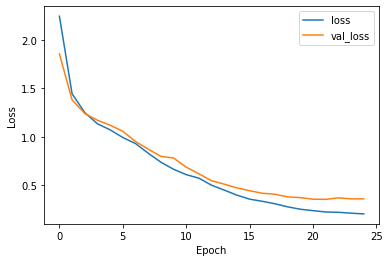

In [12]:
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(history2_2.history['loss'])
plt.plot(history2_2.history['val_loss'])
plt.legend(['loss', 'val_loss'])

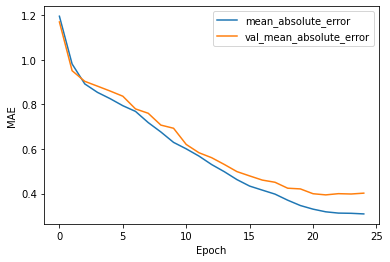

In [13]:
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.plot(history2_2.history['mean_absolute_error'])
plt.plot(history2_2.history['val_mean_absolute_error'])
plt.legend(['mean_absolute_error', 'val_mean_absolute_error'])

In [91]:
audio_sample = librosa.load('../audio_files/mono/2_basic_waves_adsr/wavs/saw/adsr_A♯1_42.wav')

In [16]:
data.head()

,file_name,wave,note,octave,note_octave,freq,attack_duration,decay_duration,sustain_level,sustain_duration,release_duration
0,sine/adsr_D♯5_1.wav.png,sine/adsr,D♯,5,D♯5,622.253967,4.013292,1.263828,0.723298,3.441122,1.159768
1,sine/adsr_E6_2.wav.png,sine/adsr,E,6,E6,1318.510228,1.617495,2.929420,0.744542,2.059110,1.812222
2,sine/adsr_C1_3.wav.png,sine/adsr,C,1,C1,32.703196,4.265106,1.609075,0.187103,1.099399,2.429497
3,sine/adsr_G8_4.wav.png,sine/adsr,G,8,G8,6271.926976,0.918339,2.958791,0.688149,1.085055,1.506915
4,sine/adsr_C♯4_5.wav.png,sine/adsr,C♯,4,C♯4,277.182631,2.069040,3.987323,0.643333,0.276730,1.975747


In [23]:
img_array = img_to_array(load_img('../audio_files/mono/2_basic_waves_adsr/adsr_plots/sine/adsr_G♯2_32.wav.png', target_size=(256, 256)))
img_batch = np.expand_dims(img_array, axis=0)
model2_2.predict(img_batch/255)

array([[ 0.8083456 ,  1.4574273 , -0.19486463,  3.5896173 ,  4.3830967 ]],
      dtype=float32)

In [25]:
data[data['file_name'].str.contains('sine/adsr_G♯2_32.wav.png')]

,file_name,wave,note,octave,note_octave,freq,attack_duration,decay_duration,sustain_level,sustain_duration,release_duration
31,sine/adsr_G♯2_32.wav.png,sine/adsr,G♯,2,G♯2,103.826174,0.244965,2.112194,0.184716,3.931044,3.711797


In [22]:
# predict an image
folder_name = '2_basic_waves_adsr'

for subfolder in listdir(adsr_path):
    if isdir(f'{adsr_path}/{subfolder}'):
        for w in listdir(f'{adsr_path}/{subfolder}'):
            # try:
            img_array = img_to_array(load_img(f'{adsr_path}/{subfolder}/{w}', target_size=(256, 256)))
            img_batch = np.expand_dims(img_array, axis=0)
            print(f'{subfolder},{w}', model2_2.predict(img_batch/255))
            break


sq,adsr_B3_1.wav.png [[2.8196044 3.0527773 0.4680479 2.0868073 2.334119 ]]
tri,adsr_C6_59.wav.png [[3.4296987 0.8225779 1.2370803 1.9399326 3.2642682]]
saw,adsr_G♯7_102.wav.png [[2.0439892 1.8475376 0.6717635 3.1656053 3.6042564]]
sine,adsr_G♯2_32.wav.png [[ 0.8083456   1.4574273  -0.19486463  3.5896173   4.3830967 ]]


#### Messing around with librosa

In [29]:
audio_sample = librosa.load('../audio_files/mono/2_basic_waves_adsr/wavs/saw/adsr_A♯1_42.wav')

In [6]:
avg_length = 22050*0.001/22050
avg_length = 22 # approx how many samples represent 0.001 seconds

avg_samp = []
for i in range(0, len(audio_sample[0]), avg_length):
    avg = None
    if i + 22 < len(audio_sample[0]) - 1:
        avg = statistics.mean(audio_sample[0][i:i+22])
    else:
        avg = statistics.mean(audio_sample[0][i:len(audio_sample[0])])
    
    avg_samp.append(avg)

In [33]:
x = 22*0.001/22.05
x

0.0009977324263038547

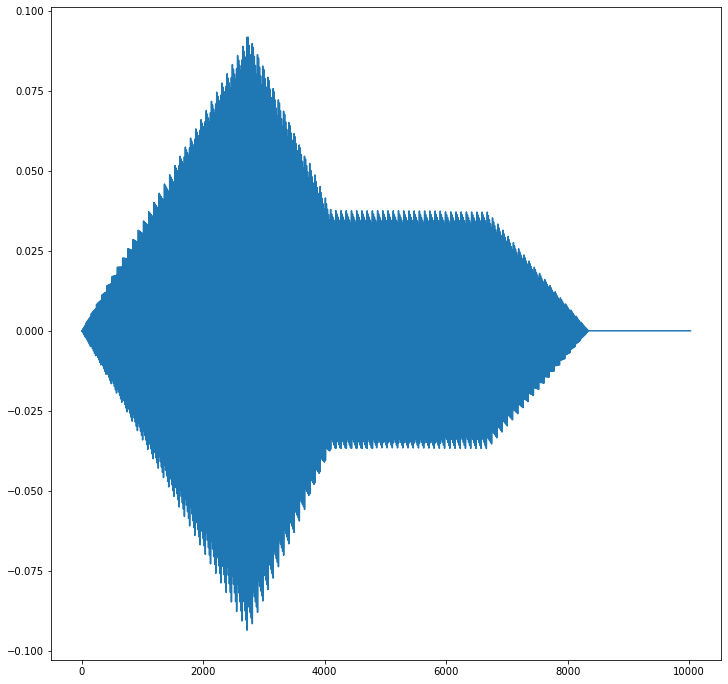

In [37]:
plt.figure(figsize=(12,12))
plt.plot(avg_samp)

In [7]:
db = librosa.amplitude_to_db(audio_sample[0], ref=np.max)

for i in range(0, len(db), len(db)//10):
    print(db[i])

-80.0
-10.204128
-11.522221
-20.523863
-11.899454
-11.218433
-21.131235
-22.040033
-25.018137
-80.0


In [18]:
data[data['file_name'].str.contains('saw/adsr_A♯1_42')]

,file_name,wave,note,octave,note_octave,freq,attack_duration,decay_duration,sustain_level,sustain_duration,release_duration
416,saw/adsr_A♯1_42.wav,saw/adsr,A♯,1,A♯1,58.27047,2.736728,1.360167,0.397736,2.570345,1.658465


In [12]:
def find_adsr(audio_file):
    sr = audio_file[1]
    db = librosa.amplitude_to_db(audio_file[0])

    peak = np.amax(db)
    peak_index = np.where(db == peak)

    # find start of sound
    curr = peak_index
    curr_avg_range = 
    for i in range(peak_index-20, 0, -20):
        if db[i] < curr:
            curr = db[i]
        else:

    return peak_index[0]/sr

find_adsr(audio_sample)

array([2.73287982])

In [26]:
librosa.amplitude_to_db(audio_sample[0])[40]

-90.16934

In [108]:
np.where(audio_sample[0] == max(audio_sample[0]))
np.where(librosa.amplitude_to_db(audio_sample[0], ref=np.max) >= 0)

(array([60260]),)

In [30]:
sign = 1 if librosa.amplitude_to_db(audio_sample[0], ref=np.max) >= 0 else -1
for idx, i in enumerate(librosa.amplitude_to_db(audio_sample[0], ref=np.max)):
    if i < 0:
        # print('negative')
        pass
    if sign == 1:
        if i >= 0:
            pass
        else:
            # print(f'sign_change at {idx}')
            sign = -1
    elif sign == -1:
        if i >= 0:
            # print(f'sign_change at {idx}')
            sign = 1
        else:
            pass

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [32]:
prev = (librosa.amplitude_to_db(audio_sample[0], ref=np.max)[0])
for idx, i in enumerate(librosa.amplitude_to_db(audio_sample[0], ref=np.max)[1:]):
    curr = i

    if i > prev:
        # print(idx, 'going up!')
        pass
    elif i < prev:
        # print(idx, 'going down!')
        pass

    prev = curr

In [8]:
.001/(22.05/22050)

1.0

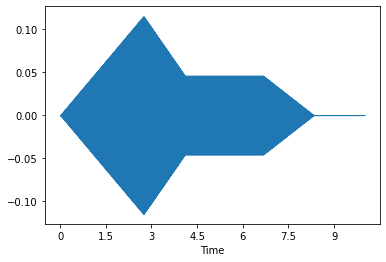

In [77]:
display.waveshow(audio_sample[0])
# display.specshow(audio_sample[0])
# D = np.abs(librosa.stft(audio_sample))
# DB = librosa.amplitude_to_db(D, ref=np.max)
# librosa.display.specshow(DB, sr=sample_rate, hop_length=512, x_axis='time', y_axis='log');


In [63]:
with plt.ioff():
    fig = plt.Figure()
    ax = fig.add_subplot(111)
    print(type(ax))
    # ax.ax display.waveshow(audio_sample[0])
    ax.axis('off')
    canvas = FigureCanvas(fig)
    canvas.print_figure(f'test2.png', bbox_inches='tight')


<class 'matplotlib.axes._subplots.AxesSubplot'>


### Group 3 - Multiple Waveforms in One Sample (3_mult_waves_detune_adsr)

In [6]:
group_folder_name = '3_mult_waves_detune_adsr'

In [75]:
wav_to_plots(folder_name=group_folder_name, subfolders=False)

Error with file at ../audio_files/mono/3_mult_waves_detune_adsr/wavs/.DS_Store


In [10]:
data1 = pd.read_csv('../audio_files/mono/3_mult_waves_detune_adsr/file_data1-500.csv')
data2 = pd.read_csv('../audio_files/mono/3_mult_waves_detune_adsr/file_data501-1000.csv')

data = pd.concat([data1, data2], axis=0, ignore_index=True)

In [14]:
data.drop('Unnamed: 0', axis=1, inplace=True)
data

,file_name,sine_wave,sine_freq,square_wave,square_freq,saw_wave,saw_freq,triangle_wave,triangle_freq,note,octave,note_octave,attack_duration,decay_duration,sustain_level,sustain_duration,release_duration
0,multi_E3_1,1,167.819950,1,170.001949,0,0.000000,1,163.849415,E,3,E3,0.729026,0.093724,0.669877,0.353123,1.316096
1,multi_E9_2,1,10556.014933,0,0.000000,0,0.000000,1,10554.851712,E,9,E9,2.721946,3.037300,0.984782,2.483477,1.757276
2,multi_A4_3,0,0.000000,0,0.000000,0,0.000000,1,433.856275,A,4,A4,2.526586,0.892528,0.284086,2.305018,0.798155
3,multi_A♯3_4,1,235.412364,1,237.418971,0,0.000000,1,229.086298,A♯,3,A♯3,2.138844,3.539654,0.136786,0.841637,3.479865
4,multi_C♯8_5,1,4430.224216,1,4426.414155,1,4441.896499,0,0.000000,C♯,8,C♯8,2.659791,3.342234,0.591390,1.505321,2.492655
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,multi_G6_996,1,1574.121065,1,1572.443533,0,0.000000,0,0.000000,G,6,G6,2.617876,1.229744,0.740289,2.801397,3.350982
996,multi_G♯4_997,1,414.388188,0,0.000000,1,414.519504,0,0.000000,G♯,4,G♯4,1.171249,4.006368,0.773784,0.984716,3.837667
997,multi_E8_998,1,5274.947269,0,0.000000,0,0.000000,0,0.000000,E,8,E8,4.015230,1.698727,0.811869,3.061411,1.224633
998,multi_E8_999,1,5281.494862,0,0.000000,0,0.000000,0,0.000000,E,8,E8,3.648484,2.571308,0.183484,3.740542,0.039666


In [15]:
data['file_name'] = data['file_name'] + '.png'

In [16]:
data.describe()

,sine_wave,sine_freq,square_wave,square_freq,saw_wave,saw_freq,triangle_wave,triangle_freq,octave,attack_duration,decay_duration,sustain_level,sustain_duration,release_duration
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.495000,1346.936593,0.483000,1194.178915,0.517000,1306.850417,0.547000,1391.653397,4.977000,2.170167,2.243849,0.500059,2.164346,2.206341
std,0.500225,3132.959992,0.499961,2786.019619,0.499961,3007.637594,0.498035,3056.134218,2.598311,1.204092,1.196024,0.291790,1.266653,1.244371
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000039,0.023410,0.001460,0.000495,0.000340
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,1.198607,1.297011,0.241028,1.136335,1.149586
50%,0.000000,0.000000,0.000000,0.000000,1.000000,39.502736,1.000000,55.175273,5.000000,2.203269,2.254154,0.508513,2.163720,2.247528
75%,1.000000,655.623173,1.000000,658.500460,1.000000,656.638496,1.000000,948.376233,7.000000,3.082438,3.148584,0.749512,3.206316,3.217513
max,1.000000,15812.153945,1.000000,15806.290098,1.000000,15806.651716,1.000000,15810.972262,9.000000,4.963610,4.992827,0.999794,4.980269,4.974095


In [40]:
# data gen
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

spec_path = f'../audio_files/mono/{group_folder_name}/spectrograms'

y_cols = ['sine_wave', 'square_wave', 'saw_wave', 'triangle_wave']

train_gen = datagen.flow_from_dataframe(
    data,
    x_col='file_name',
    y_col=y_cols,
    directory=spec_path,
    class_mode='raw',
    shuffle='False',
    batch_size=32,
    subset='training'
)

val_gen = datagen.flow_from_dataframe(
    data,
    x_col='file_name',
    y_col=y_cols,
    directory=spec_path,
    class_mode='raw',
    shuffle='False',
    batch_size=32,
    subset='validation'
)
model3_1 = Sequential()

model3_1.add(Conv2D(64, (2,2), activation='relu', input_shape=(256,256,3)))
model3_1.add(MaxPooling2D(pool_size=(2,2)))

model3_1.add(Dropout(.3))
model3_1.add(Conv2D(32, (4,4), activation='relu', input_shape=(256,256,3)))
model3_1.add(MaxPooling2D(pool_size=(4,4)))

model3_1.add(Dropout(.3))
model3_1.add(Conv2D(32, (8,8), activation='relu', input_shape=(256,256,3)))
model3_1.add(MaxPooling2D(pool_size=(4,4)))

model3_1.add(Flatten())
model3_1.add(Dense(70, activation='relu'))
model3_1.add(Dense(4, activation='sigmoid'))

es = EarlyStopping(
    monitor = 'val_accuracy',
    verbose = 1,
    mode='min',
    patience=7
)

es = EarlyStopping(
    monitor = 'val_recall',
    verbose = 1,
    mode='max',
    patience=7
)

mc = ModelCheckpoint(
    filepath='../models/model3.1mc{epoch:02d}-val_recall{val_recall:.2f}',
    monitor='val_recall',
    mode='max',
    save_best_only=True,
    initial_value_threshold=.70
)

model3_1.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        tf.keras.metrics.categorical_accuracy,
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc')
    ]
)

history3_1 = model3_1.fit(train_gen, validation_data=val_gen, epochs=100, callbacks=[es, mc])

Found 800 validated image filenames.
Found 200 validated image filenames.
Epoch 1/100
25/25 [==============================] - 48s 2s/step - loss: 0.7039 - categorical_accuracy: 1.0000 - recall: 0.3333 - auc: 0.5147 - val_loss: 0.6954 - val_categorical_accuracy: 1.0000 - val_recall: 0.0000e+00 - val_auc: 0.5542
Epoch 2/100
21/25 [========================>.....] - ETA: 6s - loss: 0.6905 - categorical_accuracy: 1.0000 - recall: 0.2523 - auc: 0.5507

KeyboardInterrupt: 

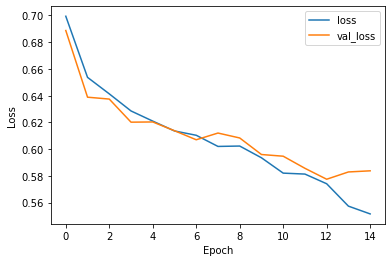

In [23]:
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(history3_1.history['loss'])
plt.plot(history3_1.history['val_loss'])
plt.legend(['loss', 'val_loss'])

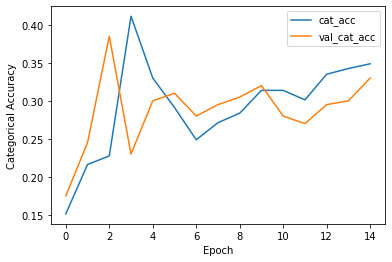

In [24]:
plt.xlabel('Epoch')
plt.ylabel('Categorical Accuracy')
plt.plot(history3_1.history['categorical_accuracy'])
plt.plot(history3_1.history['val_categorical_accuracy'])
plt.legend(['cat_acc', 'val_cat_acc'])

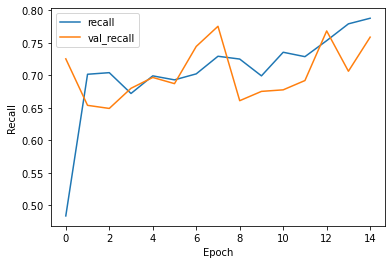

In [25]:
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.plot(history3_1.history['recall'])
plt.plot(history3_1.history['val_recall'])
plt.legend(['recall', 'val_recall'])

In [85]:
data_test = pd.read_csv('../audio_files/mono/3_mult_waves_detune_adsr/file_data1001-1501.csv').drop('Unnamed: 0', axis=1)
data_test['file_name'] = data_test['file_name'] + '.png'

In [83]:
test_datagen = ImageDataGenerator(rescale=1./255.)

test_gen = test_datagen.flow_from_dataframe(
    data_test,
    x_col='file_name',
    y_col=y_cols,
    directory=spec_path,
    class_mode='raw',
    shuffle='False',
    batch_size=32
    )
model3_1_load.evaluate(test_gen)

Found 500 validated image filenames.
16/16 [==============================] - 5s 259ms/step - loss: 0.6224 - categorical_accuracy: 0.2780 - recall: 0.8073 - auc_4: 0.6844


[0.622420608997345,
 0.27799999713897705,
 0.8073394298553467,
 0.6844391226768494]

In [88]:
test_datagen = ImageDataGenerator(rescale=1./255.)

adsr_path = f'../audio_files/mono/{group_folder_name}/adsr_plots'

test_gen = test_datagen.flow_from_dataframe(
    data_test,
    x_col='file_name',
    y_col=['attack_duration', 'decay_duration', 'sustain_level', 'sustain_duration', 'release_duration'],
    directory=adsr_path,
    class_mode='raw',
    shuffle='False',
    batch_size=32
)
model2_2_load = tf.keras.models.load_model('../models/model2.2mc22-val_mse0.35')

model2_2_load.evaluate(test_gen)

Found 500 validated image filenames.
16/16 [==============================] - 3s 195ms/step - loss: 0.6437 - mean_absolute_error: 0.5496 - mean_squared_error: 0.6437


[0.6436795592308044, 0.5496238470077515, 0.6436795592308044]

In [105]:
# data gen
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1./255.)

adsr_path = f'../audio_files/mono/{group_folder_name}/adsr_plots'

y_cols = ['attack_duration', 'decay_duration', 'sustain_level',	'sustain_duration',	'release_duration']

train_gen = datagen.flow_from_dataframe(
    data,
    x_col='file_name',
    y_col=y_cols,
    directory=adsr_path,
    class_mode='raw',
    batch_size=32,
    subset='training',
    shuffle='False'
)

val_gen = datagen.flow_from_dataframe(
    data,
    x_col='file_name',
    y_col=y_cols,
    directory=adsr_path,
    class_mode='raw',
    batch_size=32,
    subset='validation',
    shuffle='False'
)

test_gen = test_datagen.flow_from_dataframe(
    data_test,
    x_col='file_name',
    y_col=y_cols,
    directory=adsr_path,
    class_mode='raw',
    shuffle='False',
    batch_size=32
)

adsr_path = f'../audio_files/mono/{group_folder_name}/adsr_plots'

model3_2 = Sequential()

model3_2.add(Conv2D(32, (8,8), activation='relu', input_shape=(256,256,3)))
model3_2.add(MaxPooling2D(pool_size=(4,4)))

model3_2.add(Conv2D(32, (8,8), activation='relu', input_shape=(256,256,3)))
model3_2.add(MaxPooling2D(pool_size=(4,4)))

model3_2.add(Flatten())
model3_2.add(Dense(35, activation='relu'))
model3_2.add(Dense(5, activation='relu'))

es = EarlyStopping(
    monitor = 'val_mean_squared_error',
    verbose = 1,
    mode='min',
    patience=7
)

mc = ModelCheckpoint(
    filepath='../models/model3.2mc{epoch:02d}-val_mse{val_mean_squared_error:.2f}',
    monitor='val_mean_squared_error',
    mode='min',
    save_best_only=True,
    initial_value_threshold=.5
)

model3_2.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics={'output_1': 'metric_1', 'output_2': ['metric_2', 'metric_3']}
)

history3_2 = model3_2.fit(
    train_gen,
    validation_data=test_gen,
    # y=y_cols,
    # y=
    epochs=1,
    callbacks=[es, mc])

# model3_2.summary()

Found 799 validated image filenames.
Found 199 validated image filenames.
Found 500 validated image filenames.
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_32 (Conv2D)          (None, 249, 249, 32)      6176      
                                                                 
 max_pooling2d_32 (MaxPoolin  (None, 62, 62, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_33 (Conv2D)          (None, 55, 55, 32)        65568     
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 13, 13, 32)       0         
 g2D)                                                            
                                                                 
 flatten_12 (Flatten)        (None, 5408)              0         
        

/Users/kalebtsegaye/opt/anaconda3/envs/live-params/lib/python3.10/site-packages/keras_preprocessing/image/dataframe_iterator.py:279: UserWarning: Found 2 invalid image filename(s) in x_col="file_name". These filename(s) will be ignored.
  warnings.warn(
/Users/kalebtsegaye/opt/anaconda3/envs/live-params/lib/python3.10/site-packages/keras_preprocessing/image/dataframe_iterator.py:279: UserWarning: Found 2 invalid image filename(s) in x_col="file_name". These filename(s) will be ignored.
  warnings.warn(


In [115]:
model3_1.metrics

In [41]:
model3_1_load = tf.keras.models.load_model('models/model3.1mc08-val_recall0.78')

spec_img = load_img('../audio_files/mono/3_mult_waves_detune_adsr/spectrograms/multi_A♯3_4.png', target_size=(256, 256))
img_array = img_to_array(spec_img)
img_batch = np.expand_dims(img_array, axis=0)

model3_1_load.predict(img_batch)

array([[0.3178118, 1.       , 1.       , 1.       ]], dtype=float32)

In [71]:
data.shape

(1000, 17)

In [69]:
all_correct = 0
indv_correct_preds = 0

for row in data.iterrows():
    # print(row)
    spec_img = load_img(f'../audio_files/mono/3_mult_waves_detune_adsr/spectrograms/{row[1][0]}', target_size=(256, 256))
    img_array = img_to_array(spec_img)
    img_batch = np.expand_dims(img_array, axis=0)

    preds = model3_1_load.predict(img_batch)
    preds[preds<.5] = 0
    preds[preds>.5] = 1
    true = [row[1][1], row[1][3], row[1][5], row[1][7]]

    matches = sum(sum(preds == true))
    if matches == 4:
        all_correct += 1
    
    indv_correct_preds += matches



print(all_correct, indv_correct_preds)

166 2651


In [66]:
ar = np.array([[0.3178118, 1.       , 1.       , 1.       ]])
ar[ar<.5] = 0
ar[ar>.5] = 1
sum(sum(ar == [0, 1, 1, 1]))


4

In [ ]:
# estimates -> use synth code to recreate the sample -> provide a playable widget -> make spectrogram and compare pixels

In [20]:
data[y_cols].apply(lambda x: isinstance(x, object))

sine_wave        True
square_wave      True
saw_wave         True
triangle_wave    True
dtype: bool

In [ ]:
# including outside libraries
# recall, precision
# more relu layers if overfitting, dropout layers for overfitting

# make more samples to train on